# Importing Modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Importing the dataset

In [ ]:
df_train = pd.read_csv('mnist_train.csv.zip')
df_test = pd.read_csv('mnist_test.csv.zip')
df = df_train.append(df_test)

# Splitting into train, test and validation sets

In [ ]:
def train_val_test_split(data,random_state,val_size=0.2,test_size=0.1):
  """
  Train Valdiation Test split implemented from scratch. Takes the dataset,
  val_size, test_size and random_state as parameters and returns the train,
  validation and test sets.
  """
  
  shuffled_data = data.sample(frac=1,random_state=random_state)

  val_size = int(len(data)*val_size)
  test_size = int(len(data)*test_size)
  train_size = len(data)-val_size-test_size

  train = shuffled_data[:train_size]
  val = shuffled_data[train_size:train_size+val_size]
  test = shuffled_data[train_size+val_size:]

  return train,val,test

In [ ]:
df_train, df_val, df_test = train_val_test_split(df,random_state=42)

# Seperating into X and y

In [ ]:
y_train = df_train.iloc[:,0].values
X_train = df_train.iloc[:,1:].values

y_val = df_val.iloc[:,0].values
X_val = df_val.iloc[:,1:].values

y_test = df_test.iloc[:,0].values
X_test = df_test.iloc[:,1:].values

# Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Label Binarize y_train and y_val

In [ ]:
def label_binarize(y):
  y_ = np.zeros((len(y),10))
  for i in range(len(y)):
    y_[i,y[i]] = 1
  return y_

In [ ]:
y_train_binarized = label_binarize(y_train)
y_val_binarized = label_binarize(y_val)

# Accuracy 

In [ ]:
def accuracy(y_true,y_pred):
  """
  accuracy = total number of correct prediction/ total number of predictions
  """
  correct = 0
  for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
      correct += 1
  return correct/len(y_true)

# Implementing Neural Network from Scratch

In [ ]:
class myNeuralNetwork():
  """
  Implementing Neural Network from scratch
  """
  def __init__(self,N_layers,Layer_sizes,activation,weight_init,learning_rate,epochs,batch_size):
    self.N_layers = N_layers
    self.Layer_sizes = Layer_sizes
    self.activation = activation
    self.weight_init = weight_init
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.batch_size = batch_size

    #initialize arrays for storing training and validation loss v/s epochs

    self.train_loss = [0]*self.epochs
    self.val_loss = [0]*self.epochs

    #initialize activation function

    activation_func = {'ReLU':[self.relu,self.delta_relu],
                    'Leaky ReLU' : [self.leaky_relu,self.delta_leaky_relu],
                    'sigmoid': [self.sigmoid,self.delta_sigmoid],
                    'linear': [self.linear,self.delta_linear],
                    'tanh':[self.tanh,self.delta_tanh],
                    'softmax':[self.softmax,self.delta_softmax]}
    
    self.activation_ = activation_func[activation][0]
    self.delta_activation = activation_func[activation][1]

    #initialize weights and bias

    self.weights = []
    self.biases = []

    np.random.seed(0)

    for i in range(N_layers-1):
      self.biases.append(np.zeros((1,Layer_sizes[i+1])))
      if weight_init=='random':
        self.weights.append(self.random_init(Layer_sizes[i],Layer_sizes[i+1]))
      elif weight_init=='zero':
        self.weights.append(self.zero_init(Layer_sizes[i],Layer_sizes[i+1]))
      else:
        self.weights.append(self.normal_init(Layer_sizes[i],Layer_sizes[i+1])) 

  def fit(self,X_train,y_train,X_val,y_val):
      """
      Used to fit the model on given training data using forward propagation
      followed by backward propagation. The error is calculated using
      cross entropy loss function for the training and validation sets.
      """

      for i in range(self.epochs):

        #determining number of batches
        batches = len(y_train)//self.batch_size
        loss_train = 0
        loss_val = 0

        for j in range(batches):
          #finding X and y for a batch
          start = self.batch_size*j
          end = start + self.batch_size
          X = X_train[start:end,:]
          y = y_train[start:end]

          #forward propagation
          output = X
          outputs = []
          activated_outputs = []

          for k in range(self.N_layers-2):
              outputs.append(np.dot(output, self.weights[k]) + self.biases[k])
              output = self.activation_(outputs[-1])
              activated_outputs.append(output)          
          
          outputs.append(np.dot(output, self.weights[-1]) + self.biases[-1])        
          output = self.softmax(outputs[-1])
          activated_outputs.append(output)  

          #train loss
          loss_train += self.cross_entropy_loss(output,y)

          #backward propagation
          activated_outputs.insert(0,X)
          total = len(y)
  
          delta_output = self.delta_cross_entropy(y,activated_outputs[self.N_layers-1])
          delta_weights,delta_bias = self.delta_weights_bias(activated_outputs[self.N_layers-2].T,delta_output,total)
          delta_prev = np.dot(delta_output, self.weights[self.N_layers-2].T)

          derivative_weights = []
          derivative_bias = []

          derivative_weights.append(delta_weights)
          derivative_bias.append(delta_bias)

          for l in range(self.N_layers - 2, 0, -1):
              delta_output = delta_prev * self.delta_activation(outputs[l-1])
              delta_weights, delta_bias = self.delta_weights_bias(activated_outputs[l - 1].T,delta_output,total)
              delta_prev = np.dot(delta_output,self.weights[l-1].T)

              derivative_weights.append(delta_weights)
              derivative_bias.append(delta_bias)

          derivative_weights.reverse()
          derivative_bias.reverse()

          for k in range(0,self.N_layers-1):
              self.weights[k] -= self.learning_rate*derivative_weights[k]
              self.biases[k] -= self.learning_rate* derivative_bias[k]

          #validation loss
          loss_val += self.cross_entropy_loss(self.predict_proba(X_val),y_val)

        self.train_loss[i] = loss_train/batches
        self.val_loss[i] = loss_val/batches  

        print("Epoch ",(i+1),"/",self.epochs,", Train Loss : ",self.train_loss[i]," , Validation Loss: ",self.val_loss[i])

  def delta_weights_bias(self,activated_output,delta_output,total):
    """
    Calculates and returns the derivative of weights and bias
    """
    delta_weights = np.dot(activated_output, delta_output)/total
    delta_bias = np.sum(delta_output, axis=0) /total
    return delta_weights,delta_bias

  def predict_proba(self, X_test):
      """
      Predicts the output probabilities of different classes for the given test
      set using forward propagation.
      """
      output = X_test

      for i in range(self.N_layers-2):
          Z = np.dot(output, self.weights[i]) + self.biases[i]
          output = self.activation_(Z)         
      
      Z = np.dot(output, self.weights[-1]) + self.biases[-1]    
      return self.softmax(Z)

  def predict(self, X_test):
      """
      Predict the output for the given test set using forward propagation.
      """
      output = X_test

      for i in range(self.N_layers-2):
          Z = np.dot(output, self.weights[i]) + self.biases[i]
          output = self.activation_(Z)         
      
      Z = np.dot(output, self.weights[-1]) + self.biases[-1]    
      output = self.softmax(Z)
      return np.argmax(output,axis=1)

  def cross_entropy_loss(self, y_pred, y_true):
    """
    Calculates and returns the cross entropy loss
    """
    y_pred = np.clip(y_pred, 1e-7, None)
    return -np.mean(np.multiply(y_true,np.log(y_pred)))

  def delta_cross_entropy(self,y_true,y_pred): 
    """
    Returns the gradient of cross entropy loss
    """
    return y_pred-y_true

  def random_init(self,input_size,output_size):
    """
    random_initialization with scaling factor of 0.01
    """
    return np.random.rand(input_size,output_size)*0.01
  
  def zero_init(self,input_size,output_size):
    """
    zero initialization
    """
    return np.zeros((input_size,output_size))
  
  def normal_init(self,input_size,output_size):
    """
    normal initialization with scaling factor of 0.01
    """
    return np.random.randn(input_size,output_size)*0.01

  def relu(self,X):
    """
    f(x) = max(0,x)
    """
    return X * (X>0)

  def delta_relu(self,X):
    """
    f'(x) = 0 if x<0
            1 if x>0
    """
    return 1.0 * (X>0)

  def leaky_relu(self,X):
    """
    f(x) = max(0.01*x,x)
    """
    return np.where(X>0,X,0.01*X)
  
  def delta_leaky_relu(self,X):
    """
    f'(x) = 0.01 if x<0
            1 if x>0
    """
    dX = np.ones_like(X)
    dX[X<0] = 0.01
    return dX

  def sigmoid(self,X):
    """
    f(x) = 1/ ( 1 + e^-x)
    """
    return 1/ (1+ np.exp(-X))

  def delta_sigmoid(self,X):
    """
    f'(x) = f(x) * ( 1 - f(x))
    """
    X = self.sigmoid(X)
    return X * (1-X)

  def linear(self,X):
    """
    f(x) = x
    """
    return X
  
  def delta_linear(self,X):
    """
    f'(x) = 1
    """
    return np.ones(X.shape)

  def tanh(self,X):
    return np.tanh(X)

  def delta_tanh(self,X):
    """
    gradient of tanh is 1 - tanh(x)^2
    """
    return 1 - np.tanh(X)**2

  def softmax(self,X):
    X = np.exp(X)
    return X/np.sum(X,axis=1,keepdims=True)

  def delta_softmax(self,X):
    X = self.softmax(X)
    return -np.outer(X,X) + np.diag(X.flatten())

  def score(self,y_true,y_pred):
    """
    Returns the accuracy of the model
    """
    return accuracy(y_true,y_pred)

  def plot(self):
    """
    Function for plotting the Training and Validation loss v/s Iterations
    """
    plt.plot(list(range(self.epochs)),self.train_loss,label='Training')
    plt.plot(list(range(self.epochs)),self.val_loss,label='Validation')
    plt.title("Loss v/s Epochs With Learning Rate = "+str(self.learning_rate)+", Activation = "+str(self.activation)+" , weight_init = "+str(self.weight_init),y=1.08)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(str(self.activation)+" "+str(self.learning_rate)+" "+str(self.weight_init)+".png")
    plt.show()

# 1 and 2

Accuracy:  0.495 



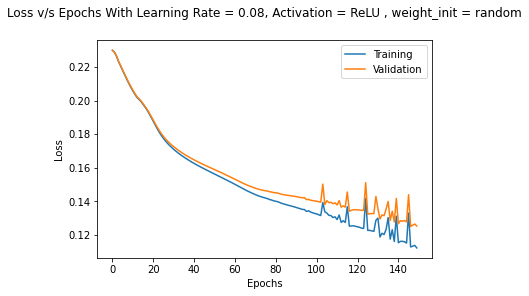

Accuracy:  0.11814285714285715 



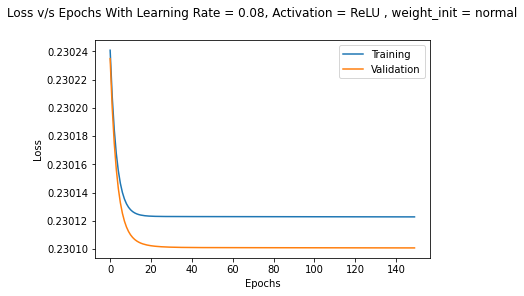

Accuracy:  0.42428571428571427 



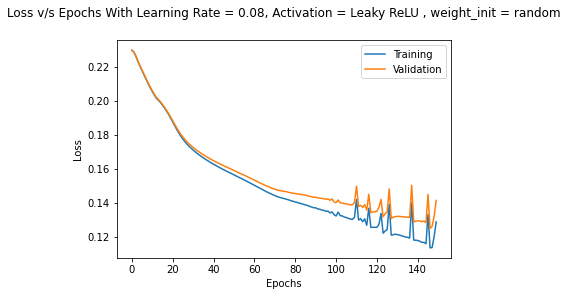

Accuracy:  0.11814285714285715 



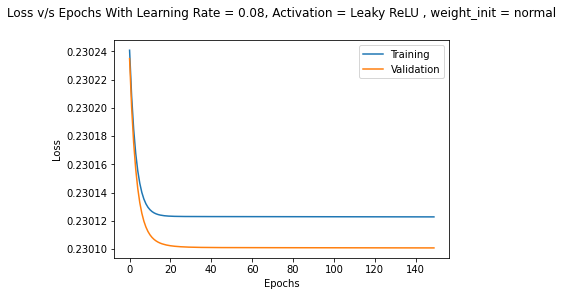

Accuracy:  0.11814285714285715 



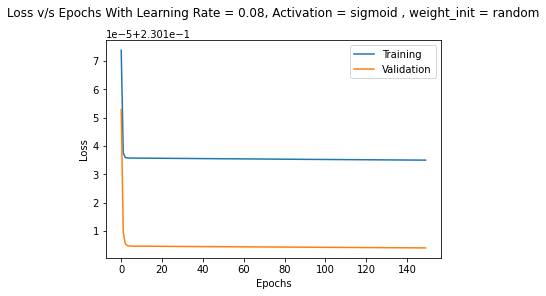

Accuracy:  0.11814285714285715 



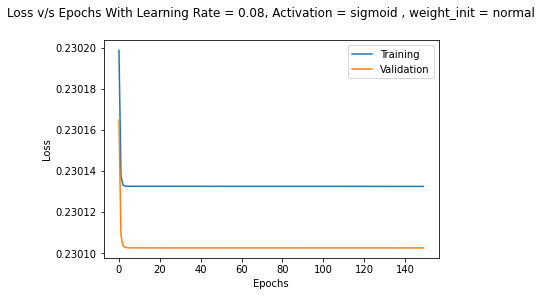

Accuracy:  0.38971428571428574 



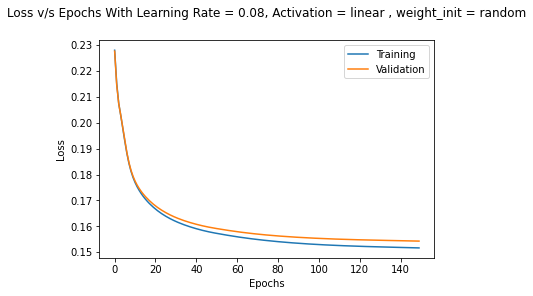

Accuracy:  0.11814285714285715 



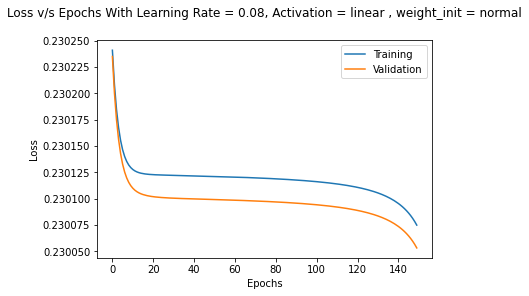

Accuracy:  0.7761428571428571 



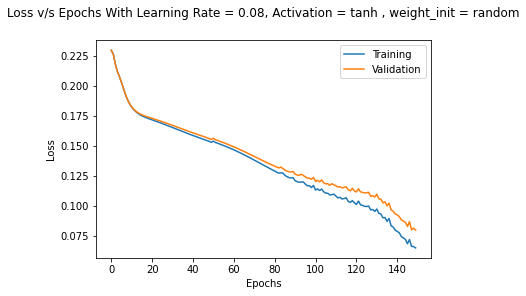

Accuracy:  0.11814285714285715 



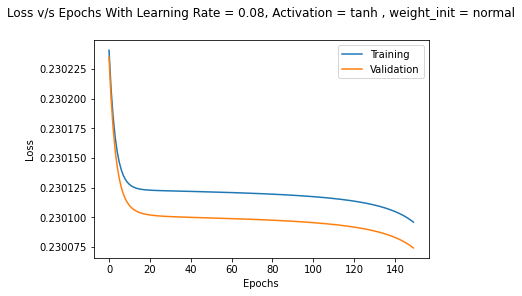

In [ ]:
hidden_layer_activation_functions = ['ReLU','Leaky ReLU','sigmoid','linear','tanh']
batch_size_ = len(y_train)//20
weights_init_method = ['random','normal']

for func in hidden_layer_activation_functions:
  for method in weights_init_method:
    filename = str(func) + " "+ str(0.08)+" "+str(method)+".pickle"
    if not os.path.exists(filename):

      neural_network = myNeuralNetwork(N_layers=6,Layer_sizes=[784,256,128,64,32,10],activation=func,epochs=150,weight_init=method,learning_rate=0.08,batch_size=batch_size_)
      neural_network.fit(X_train,y_train_binarized,X_val,y_val_binarized)

      with open(filename,'wb') as file:
        pickle.dump(neural_network,file)

    with open(filename,'rb') as file:
      model_ = pickle.load(file)

    y_pred = model_.predict(X_test)
    print("Accuracy: ",model_.score(y_test,y_pred),"\n")
    model_.plot()

# 5

Accuracy for learning_rate =  0.001  and weight_init =  random  :  0.19342857142857142


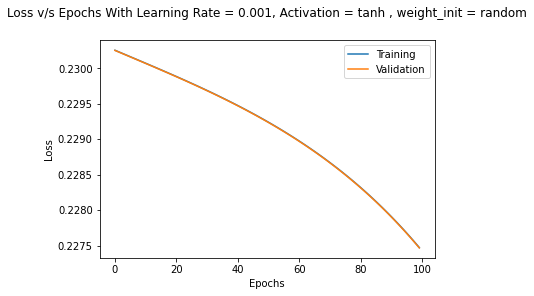

Accuracy for learning_rate =  0.001  and weight_init =  normal  :  0.11814285714285715


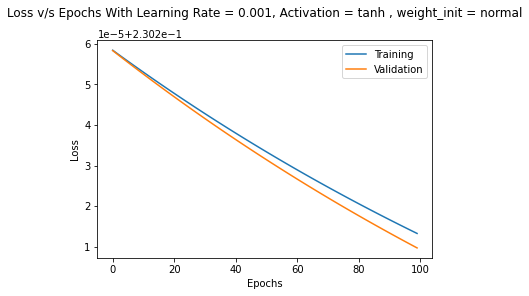

Accuracy for learning_rate =  0.01  and weight_init =  random  :  0.21628571428571428


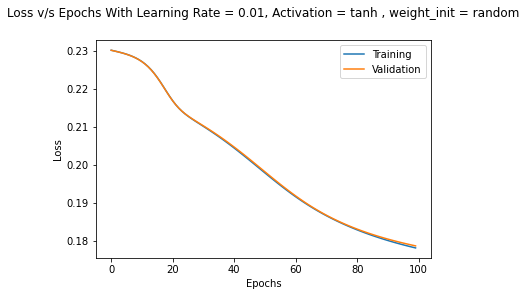

Accuracy for learning_rate =  0.01  and weight_init =  normal  :  0.11814285714285715


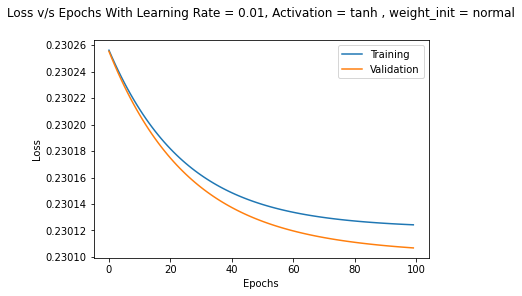

Accuracy for learning_rate =  0.1  and weight_init =  random  :  0.6235714285714286


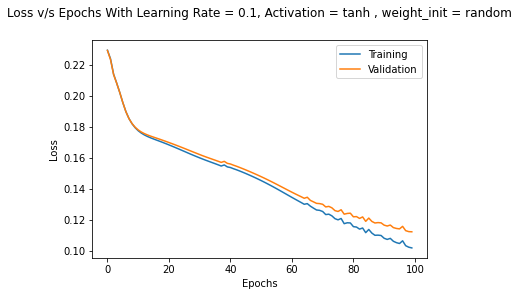

Accuracy for learning_rate =  0.1  and weight_init =  normal  :  0.11814285714285715


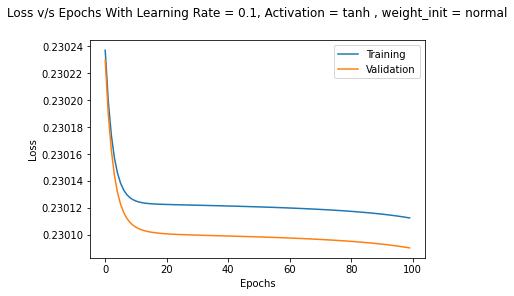

Accuracy for learning_rate =  1.0  and weight_init =  random  :  0.9552857142857143


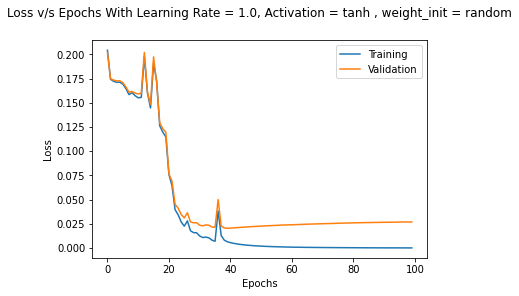

Accuracy for learning_rate =  1.0  and weight_init =  normal  :  0.9574285714285714


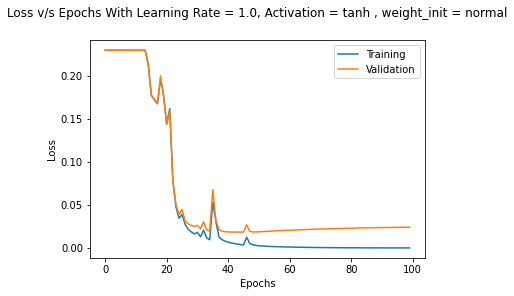

In [ ]:
batch_size_ = len(y_train)//20
weights_init_method = ['random','normal']
learning_rates = [0.001,0.01,0.1,1.0]

for lr in learning_rates:
  for method in weights_init_method:
    filename = str('tanh') + " "+ str(lr)+" "+str(method)+".pickle"
    if not os.path.exists(filename):

      neural_network = myNeuralNetwork(N_layers=6,Layer_sizes=[784,256,128,64,32,10],activation='tanh',epochs=100,weight_init=method,learning_rate=lr,batch_size=batch_size_)
      neural_network.fit(X_train,y_train_binarized,X_val,y_val_binarized)

      with open(filename,'wb') as file:
        pickle.dump(neural_network,file)

    with open(filename,'rb') as file:
      model_ = pickle.load(file)

    y_pred = model_.predict(X_test)
    print("Accuracy for learning_rate = ",lr," and weight_init = ",method," : ",model_.score(y_test,y_pred))
    model_.plot()

# 4

In [ ]:
activations = ['relu','logistic','identity','tanh']


for func in activations:
  filename = 'sklearn ' + func 
  if not os.path.exists(filename):
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation=func,learning_rate_init=0.08,random_state=0,max_iter=150,batch_size=len(y_train)//20)
    mlp_classifier.fit(X_train,y_train)

    with open(filename,'wb') as file:
      pickle.dump(mlp_classifier, file)


  with open(filename,'rb') as file:
    mlp_classifier_ = pickle.load(file)

  y_pred = mlp_classifier_.predict(X_test)
  print("Accuracy using activation = ",func," is ",accuracy(y_test,y_pred))

Accuracy using activation =  relu  is  0.11814285714285715
Accuracy using activation =  logistic  is  0.11814285714285715
Accuracy using activation =  identity  is  0.9177142857142857
Accuracy using activation =  tanh  is  0.9042857142857142
